# Import packages

In [1]:
import pandas as pd
from scipy.stats import ttest_rel

import matplotlib.pyplot as plt
import ptitprince as pt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc, roc_curve, RocCurveDisplay, r2_score,\
    mean_absolute_error, mean_squared_error, recall_score, accuracy_score, f1_score, \
    precision_score, balanced_accuracy_score, roc_auc_score

import seaborn as sns

# Custom functions

In [2]:
from pickle_managment import load_pickle
from model_evaluation import delongs_test

# Regression

## Load pickles

In [3]:
regression_X_train = load_pickle(
    r'model_outputs\rf_regressor\regression_X_train.pkl')
regression_y_train = load_pickle(
    r'model_outputs\rf_regressor\regression_y_train.pkl')
regression_X_test = load_pickle(
    r'model_outputs\rf_regressor\regression_X_test.pkl')
regression_y_test = load_pickle(
    r'model_outputs\rf_regressor\regression_y_test.pkl')

best_rf_regressor = load_pickle(r'model_pickles\best_rf_regressor.pkl')
best_svm_regressor = load_pickle(r'model_pickles\best_svm_regressor.pkl')

In [4]:
y_pred_rf_train = best_rf_regressor.predict(regression_X_train)
y_pred_rf_test = best_rf_regressor.predict(regression_X_test)

y_pred_svm_train = best_svm_regressor.predict(regression_X_train)
y_pred_svm_test = best_svm_regressor.predict(regression_X_test)

In [5]:
rf_residual_train = regression_y_train - y_pred_rf_train
rf_residual_test = regression_y_test - y_pred_rf_test

rf_residual_train = rf_residual_train.reset_index(drop=True)
rf_residual_test = rf_residual_test.reset_index(drop=True)

In [6]:
#Calculate residuals
svm_residual_train = regression_y_train - y_pred_svm_train
svm_residual_test = regression_y_test - y_pred_svm_test

svm_residual_train = svm_residual_train.reset_index(drop=True)
svm_residual_test = svm_residual_test.reset_index(drop=True)

## p-values
F-stat will be hard to calculate since the number of parameters in the RF
regressor is tricky to determine. Instead, a student t-test will be
performed to compare the errors to check whether the 2 regressors'
performances are significantly different.

### Train set

In [7]:
t_statistic, p_value = ttest_rel(svm_residual_train, rf_residual_train)

print('p-value between 2 models on the train set:', p_value)

p-value between 2 models on the train set: 0.32015568376611064


### Test set

In [8]:
t_statistic, p_value = ttest_rel(svm_residual_test, rf_residual_test)

print('p-value between 2 models on the test set:', p_value)

p-value between 2 models on the test set: 0.059934403693197115


## Both regressors' residuals on train set

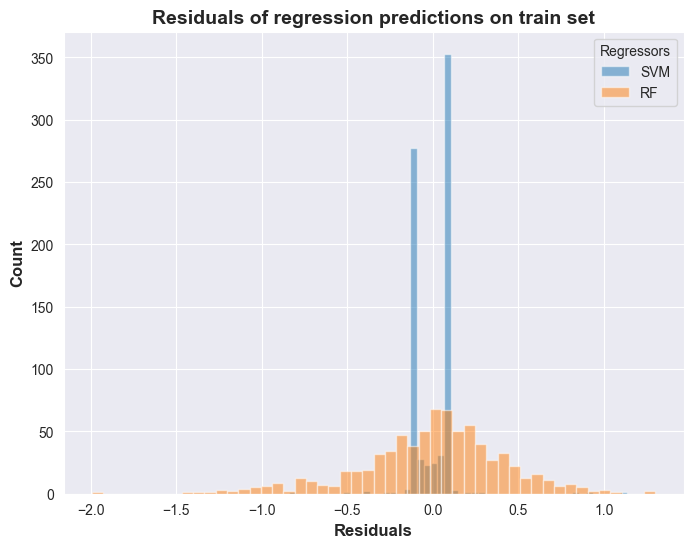

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.hist(svm_residual_train, bins=50, alpha=0.5, label='SVM')
plt.hist(rf_residual_train, bins=50, alpha=0.5, label='RF')

plt.xlabel('Residuals', weight='bold', fontsize=12)
plt.ylabel('Count', weight='bold', fontsize=12)
plt.title('Residuals of regression predictions on train set', weight='bold',
          fontsize=14)
plt.legend(title='Regressors')

plt.savefig(
    r'model_outputs\model_comparisions\svm_rf_train_residuals.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

In [10]:
melted_df = pd.concat([svm_residual_train, rf_residual_train], axis=0,
                      keys=['svm', 'rf'])
melted_df = melted_df.reset_index()
melted_df.columns = ['regressor', 'index', 'residual']  # Rename columns

# Drop the 'index' column if not needed
melted_df = melted_df.drop(columns=['index'])
melted_df

,regressor,residual
0,svm,0.099902
1,svm,-0.100066
2,svm,-0.100411
3,svm,-0.099724
4,svm,0.099666
...,...,...
1507,rf,-0.857058
1508,rf,-0.025219
1509,rf,-0.182285
1510,rf,-0.226449


## Both regressors' residuals on test set

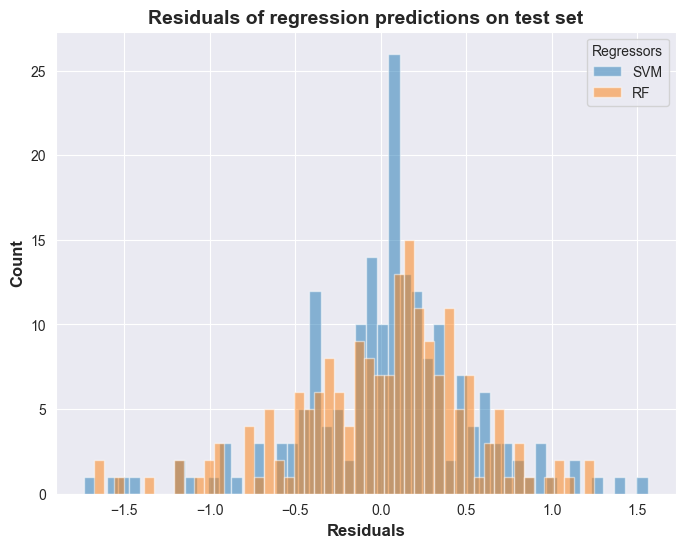

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.hist(svm_residual_test, bins=50, alpha=0.5, label='SVM')
plt.hist(rf_residual_test, bins=50, alpha=0.5, label='RF')

plt.xlabel('Residuals', weight='bold', fontsize=12)
plt.ylabel('Count', weight='bold', fontsize=12)
plt.title('Residuals of regression predictions on test set', weight='bold',
          fontsize=14)
plt.legend(title='Regressors')

plt.savefig(
    r'model_outputs\model_comparisions\svm_rf_test_residuals.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

## Compare side by side

In [12]:
# Concatenate the Series along the rows
regressors_compare_df = pd.concat(
    [svm_residual_train, svm_residual_test, rf_residual_train,
     rf_residual_test], axis=0, ignore_index=True)

# Create a list to store the original series names
series_names = ['svm_residual_train'] * len(svm_residual_train) + [
    'svm_residual_test'] * len(svm_residual_test) + [
                   'rf_residual_train'] * len(rf_residual_train) + [
                   'rf_residual_test'] * len(rf_residual_test)

# Create DataFrame with 'value', 'source', and 'series_name' columns
regressors_compare_df = pd.DataFrame(
    {'Residuals': regressors_compare_df, 'source': series_names})

# Split 'source' column into 'datasets' and 'regressors' columns
regressors_compare_df[['Regressors', 'intermediate_str']] =regressors_compare_df['source'].str.split('_', n=1,
                                          expand=True)
regressors_compare_df[['useless', 'Datasets']] = regressors_compare_df[
    'intermediate_str'].str.split('_', n=1,
                                  expand=True)
# Drop the original 'source' column
regressors_compare_df = regressors_compare_df.drop(
    columns=['source', 'intermediate_str', 'useless'])
regressors_compare_df = regressors_compare_df[['Regressors', 'Datasets',
                                               'Residuals']]
regressors_compare_df

,Regressors,Datasets,Residuals
0,svm,train,0.099902
1,svm,train,-0.100066
2,svm,train,-0.100411
3,svm,train,-0.099724
4,svm,train,0.099666
...,...,...,...
1885,rf,test,0.615361
1886,rf,test,0.392079
1887,rf,test,-0.982204
1888,rf,test,-0.301559


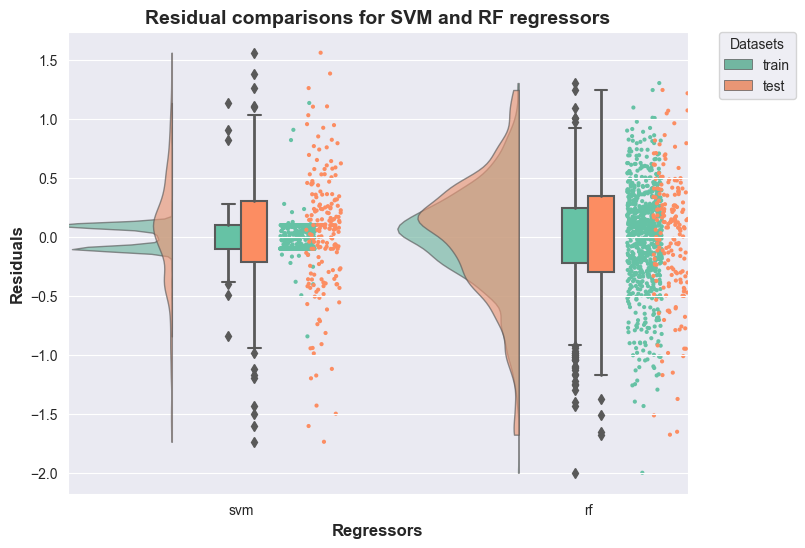

In [13]:
f, ax = plt.subplots(figsize=(8, 6))
ax = pt.RainCloud(
    x='Regressors',
    order=['svm', 'rf'],
    y='Residuals',
    hue='Datasets',
    hue_order=['train', 'test'],
    data=regressors_compare_df,
    palette='Set2',
    bw=0.2,
    width_viol=.7,
    ax=ax,
    orient='v',
    move=.2,
    alpha=0.65,
    dodge=True
)
ax.set_title('Residual comparisons for SVM and RF regressors',
             weight='bold', fontsize=14)
ax.set_xlabel('Regressors', fontsize=12, fontweight='bold')
ax.set_ylabel('Residuals', fontsize=12, fontweight='bold')
plt.savefig(
    r'model_outputs\model_comparisions\same_model_different_datasets.png',
    dpi=600,
    bbox_inches='tight'
)

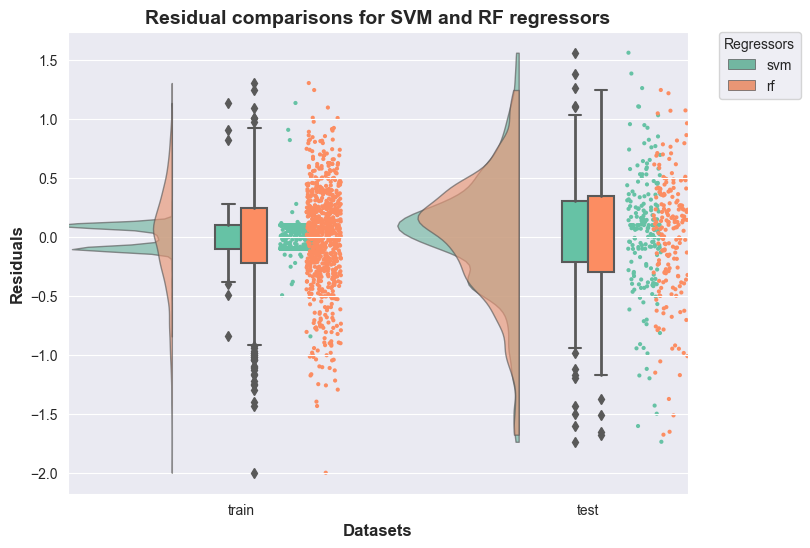

In [14]:
f, ax = plt.subplots(figsize=(8, 6))
ax = pt.RainCloud(
    x='Datasets',
    order=['train', 'test'],
    y='Residuals',
    hue='Regressors',
    hue_order=['svm', 'rf'],
    data=regressors_compare_df,
    palette='Set2',
    bw=0.2,
    width_viol=.7,
    ax=ax,
    orient='v',
    move=.2,
    alpha=0.65,
    dodge=True
)
ax.set_title('Residual comparisons for SVM and RF regressors',
             fontweight='bold', fontsize=14)
ax.set_xlabel('Datasets', fontweight='bold', fontsize=12)
ax.set_ylabel('Residuals', fontweight='bold', fontsize=12)
plt.savefig(
    r'model_outputs\model_comparisions\same_datasets_different_models.png',
    dpi=600,
    bbox_inches='tight'
)

# Classification

## Load pickles

In [15]:
centroid_svm = load_pickle(r'model_pickles\best_svm_classifier_centroid.pkl')

mlp_classifier = load_pickle(r'model_pickles\best_mlp_classifier.pkl')

X_classifier = load_pickle\
    (r'model_outputs\mlp_classifier\classification_X_test.pkl')
y_classifier = load_pickle\
    (r'model_outputs\mlp_classifier\classification_y_test.pkl')

## ROC curve

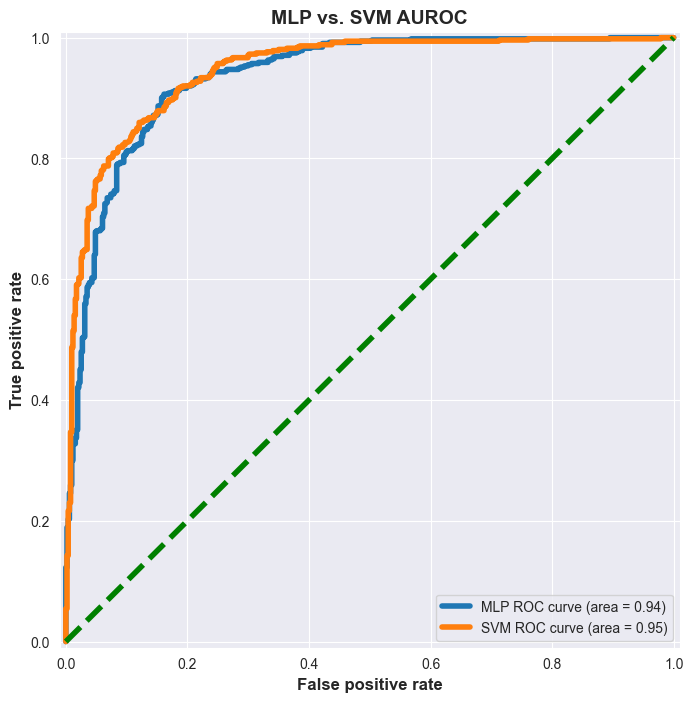

In [16]:
positive_label_index = 0
y_mlp_probabilities=mlp_classifier.predict_proba(X_classifier)[:, positive_label_index]
y_svm_probabilities=centroid_svm.predict_proba(X_classifier)[:, positive_label_index]

# Compute ROC curve and ROC area for each class
fpr_mlp, tpr_mlp, _ = roc_curve(y_classifier, y_mlp_probabilities,
                                pos_label='BBB+')
fpr_svm, tpr_svm, _ = roc_curve(y_classifier, y_svm_probabilities,
                                pos_label='BBB+')
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fig, ax = plt.subplots(figsize=(8, 8))

plt.plot(
    fpr_mlp,
    tpr_mlp,
    lw=4,
    label='MLP ROC curve (area = %0.2f)' % roc_auc_mlp
)
plt.plot(
    fpr_svm,
    tpr_svm,
    lw=4,
    label='SVM ROC curve (area = %0.2f)' % roc_auc_svm
)
plt.plot(
    [0, 1],
    [0, 1],
    color='green',
    lw=4,
    linestyle='--'
)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate',weight='bold', fontsize=12)
plt.ylabel('True positive rate',weight='bold', fontsize=12)
plt.title('MLP vs. SVM AUROC',weight='bold', fontsize=14)
plt.legend(loc='lower right')

plt.savefig(
    r'model_outputs\model_comparisions\auroc.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

## DeLong's test

In [17]:
centroid_probs = centroid_svm.predict_proba(X_classifier)

mlp_probs = mlp_classifier.predict_proba(X_classifier)

centroid_auc = roc_auc_score(y_classifier, centroid_probs[:, 1])

mlp_auc = roc_auc_score(y_classifier, mlp_probs[:, 1])

In [18]:
new_centroid_probs = centroid_probs[:,1]
new_mlp_probs = mlp_probs[:,1]

In [19]:
y_true = y_classifier.values
np.delete(y_true, 1)

for i in range(len(y_true)):
    if y_true[i] == 'BBB+':
        y_true[i] = 1
    else:
        y_true[i] = 0


In [20]:
delongs_test(new_centroid_probs, new_mlp_probs, centroid_auc, mlp_auc, y_classifier)

Model A's V10: [0.007782101167315175, 0.03696498054474708, 0.12840466926070038, 0.18093385214007782, 0.0, 0.10700389105058365, 0.011673151750972763, 0.0019455252918287938, 0.0038910505836575876, 0.0, 0.0038910505836575876, 0.01556420233463035, 0.0038910505836575876, 0.11089494163424124, 0.24124513618677043, 0.0, 0.03696498054474708, 0.017509727626459144, 0.04669260700389105, 0.007782101167315175, 0.0019455252918287938, 0.2607003891050584, 0.009727626459143969, 0.009727626459143969, 0.01556420233463035, 0.21595330739299612, 0.0038910505836575876, 0.048638132295719845, 0.017509727626459144, 0.0, 0.03696498054474708, 0.0019455252918287938, 0.009727626459143969, 0.011673151750972763, 0.0019455252918287938, 0.009727626459143969, 0.007782101167315175, 0.027237354085603113, 0.009727626459143969, 0.04669260700389105, 0.3638132295719844, 0.013618677042801557, 0.10311284046692606, 0.0, 0.0622568093385214, 0.03501945525291829, 0.017509727626459144, 0.017509727626459144, 0.03501945525291829, 0.110

0.06259081582131595

# Prep holdout data

## Regression holdout

In [21]:
#Read in data
regression_holdout_df = pd.read_csv(
    r'datasets\holdout_datasets\regression_df_expanded_cleaned_holdout.csv.zip'
)
regression_holdout_df

,SMILES,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,158_y,159_y,160_y,161_y,162_y,163_y,164_y,165_y,166_y,logBB
0,CC1=CN(C(=O)NC1=O)[C@@H]2C[C@@H]([C@@H](O2)CO)...,11.700274,11.700274,0.264561,-0.670648,0.445400,26.105263,267.245,254.141,267.096754,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-0.72
1,C1=CC(=C(C=C1C(=O)NC2=CN=C(C=C2)Cl)F)F,12.946453,12.946453,0.017454,-1.072332,0.849604,10.166667,268.650,261.594,268.021497,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.44
2,CC(=C)C(=O)/C(=C\C(=O)O)/OC,11.053380,11.053380,0.212963,-1.220880,0.499061,10.666667,170.164,160.084,170.057909,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.79
3,CC1=CC(=CC=C1)C,2.166667,2.166667,1.337963,1.337963,0.475758,9.250000,106.168,96.088,106.078250,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.20
4,C(=C/F)\O/C=C/F,10.854583,10.854583,0.166667,0.166667,0.488155,11.142857,106.071,102.039,106.023021,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,Nc1c2c(NC(C)C(c3ccccc3)=N2)cc(CC(OCC)=O)n1,11.642240,11.642240,0.025133,-0.317885,0.844065,15.916667,324.384,304.224,324.158626,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.27
102,CC1(C2CCC3(C(C2(CCC1O)C)C(=O)C=C4C3(CCC5(C4CC(...,14.202352,14.202352,0.029556,-0.711072,0.464074,54.117647,470.694,424.326,470.339610,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,-1.40
103,C1=CC=NC(=C1)CSCCNC2=C(C=CN2)[N+](=O)[O-],10.688823,10.688823,0.078450,-0.402912,0.461899,10.315789,278.337,264.225,278.083747,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,-0.66
104,C1CN(CC1C(C2=CC=CC=C2)(C3=CC=CC=C3)C(=O)N)CCC4...,13.195604,13.195604,0.137241,-0.817283,0.622271,18.312500,426.560,396.320,426.230728,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,-0.62


In [22]:
#Load pickles
rf_regressor = load_pickle(
    r'model_pickles\best_rf_regressor.pkl')
regression_pipeline = load_pickle(r'model_outputs\svr_regressor\svm_regressor_pipeline.pkl')

In [23]:
#Create X and y from holdout data frame
regression_holdout_X = regression_holdout_df.drop(['SMILES', 'logBB'],axis=1)

#Process X to fit model
regressor_X_processed = regression_pipeline.transform(regression_holdout_X)

regression_holdout_y = regression_holdout_df['logBB']

In [24]:
mae_list = []
mse_list = []
r2_list = []
for data_X, data_y in [[regression_holdout_X, regression_holdout_y]]:
    y_predict = rf_regressor.predict(data_X)

    mae = mean_absolute_error(np.copy(data_y), y_predict)
    mse = mean_squared_error(np.copy(data_y), y_predict)
    r2 = r2_score(np.copy(data_y), y_predict)

    mae_list.append(mae)
    mse_list.append(mse)
    r2_list.append(-r2)

performance_df = pd.DataFrame(
    {
        'Dataset': ['RF Holdout'],
        'MAE': mae_list,
        'MSE': mse_list,
        'R2': r2_list
    }
)

performance_df_melted = performance_df.melt(id_vars='Dataset',
                                            var_name='Metric',
                                            value_name='Value')
performance_df_melted

,Dataset,Metric,Value
0,RF Holdout,MAE,0.722199
1,RF Holdout,MSE,0.709312
2,RF Holdout,R2,0.418375


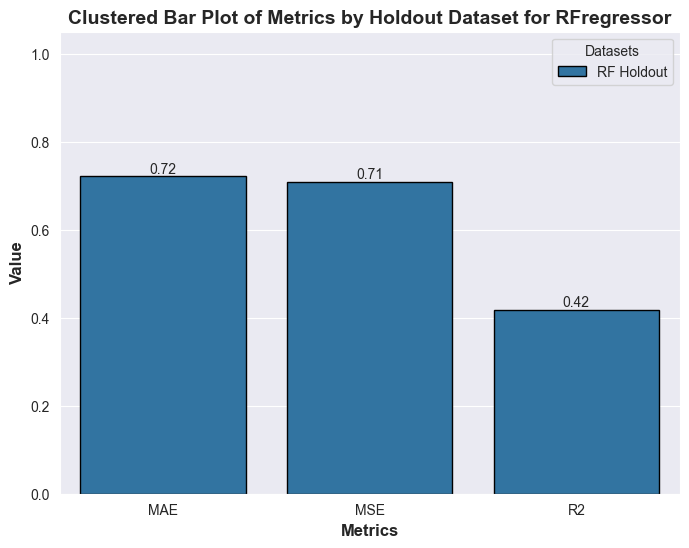

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

ax = sns.barplot(data=performance_df_melted, x='Metric', y='Value',
                 hue='Dataset',
                 edgecolor='black')

for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.2f'  #Round the data label to the 2 decimal places
    )
plt.ylim(0, 1.05)
plt.xlabel('Metrics', weight='bold', fontsize=12)
plt.ylabel('Value', weight='bold', fontsize=12)
plt.title('Clustered Bar Plot of Metrics by Holdout Dataset for RF'
          'regressor',
          weight='bold', fontsize=14)
plt.legend(title='Datasets')

plt.savefig(
    r'model_outputs\model_comparisions\rf_holdout_metrics.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

## Classification holdout

In [26]:
classification_holdout_df = pd.read_csv(
    r'datasets\holdout_datasets\classification_df_expanded_cleaned_holdout.csv.zip'
)
classification_holdout_df

,SMILES,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,158_y,159_y,160_y,161_y,162_y,163_y,164_y,165_y,166_y,BBB+/BBB-
0,c1ccc2c(c1)CCc1ccccc1N2C1CN2CCC1CC2,2.702037,2.702037,0.636944,0.636944,0.785000,28.869565,304.437,280.245,304.193949,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,BBB+
1,CN(C)CCN1C(=O)CC(c2ccccc2)Sc2ccccc21,12.867357,12.867357,0.175191,0.175191,0.853240,17.956522,326.465,304.289,326.145284,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,BBB+
2,COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(N)C3=O)N1C[C@...,12.770676,12.770676,0.058604,-0.957338,0.410670,36.750000,334.332,316.188,334.127720,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,BBB-
3,C[C@@H]1[C@H]2Cc3ccc(O)cc3[C@]1(C)CCN2CC1CC1,9.854940,9.854940,0.247064,0.247064,0.891630,36.700000,271.404,246.204,271.193614,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,BBB+
4,COC(=O)[C@H]1NC(=O)[C@H]2NC(=O)[C@@H](NC(=O)[C...,16.191284,16.191284,0.014526,-2.350019,0.110163,25.549020,1446.182,1383.686,1444.325400,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,BBB-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,CCC(=C(c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1,5.870988,5.870988,0.692414,0.692414,0.450573,12.000000,371.524,342.292,371.224915,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,BBB+
777,C[N+]1(C)CCCC(OC(=O)C(O)(c2ccccc2)c2ccccc2)C1,13.065964,13.065964,0.171112,-1.794534,0.687558,20.040000,340.443,314.235,340.190720,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,BBB-
778,C/C=C/C(=O)N(CC)c1ccccc1C,11.766069,11.766069,0.036389,0.036389,0.691577,10.600000,203.285,186.149,203.131014,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,BBB-
779,CC1(C)O[C@@H]2CC3C4CC[C@H]5CC(=O)CC[C@]5(C)[C@...,17.225172,17.225172,0.060763,-1.821031,0.688737,55.193548,438.536,403.256,438.241767,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,BBB+


In [27]:
#Load pickles
categorical_pipeline = load_pickle(
    r'model_outputs\svm_classifier\centroid_pipeline.pkl'
)
svm_model = load_pickle(r'model_pickles\best_svm_classifier_centroid.pkl')

In [28]:
classification_holdout_X = classification_holdout_df.drop(['SMILES', 'BBB+/BBB-'],axis=1)


X_processed = categorical_pipeline.transform(classification_holdout_X)

classification_holdout_y = classification_holdout_df['BBB+/BBB-']


In [29]:
classification_holdout_X

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,157_y,158_y,159_y,160_y,161_y,162_y,163_y,164_y,165_y,166_y
0,2.702037,2.702037,0.636944,0.636944,0.785000,28.869565,304.437,280.245,304.193949,118.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
1,12.867357,12.867357,0.175191,0.175191,0.853240,17.956522,326.465,304.289,326.145284,120.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,12.770676,12.770676,0.058604,-0.957338,0.410670,36.750000,334.332,316.188,334.127720,128.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
3,9.854940,9.854940,0.247064,0.247064,0.891630,36.700000,271.404,246.204,271.193614,108.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,16.191284,16.191284,0.014526,-2.350019,0.110163,25.549020,1446.182,1383.686,1444.325400,532.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,5.870988,5.870988,0.692414,0.692414,0.450573,12.000000,371.524,342.292,371.224915,144.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
777,13.065964,13.065964,0.171112,-1.794534,0.687558,20.040000,340.443,314.235,340.190720,132.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
778,11.766069,11.766069,0.036389,0.036389,0.691577,10.600000,203.285,186.149,203.131014,80.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
779,17.225172,17.225172,0.060763,-1.821031,0.688737,55.193548,438.536,403.256,438.241767,174.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


In [30]:
X_processed

array([[ -8.0152492 ,  -2.18010827,   6.6750464 , ...,   3.6553672 ,
          1.62801149,   1.60903102],
       [ -6.43617574,   0.92045391,   4.34131674, ...,  -1.27736753,
          1.27066941,   0.24756473],
       [  3.09386348,   1.2378494 ,  -4.07248738, ...,  -0.17183587,
          0.07758695,   0.52459677],
       ...,
       [ -8.75743538,  -1.69842786,   0.31310635, ...,   0.73310994,
         -0.45257567,  -0.76234735],
       [  7.50764764, -14.51922501, -11.66131399, ...,  -0.75953099,
          0.41495286,  -1.11877041],
       [ -4.34122833,  -0.92519622,   7.28096153, ...,  -0.49618632,
          0.33072646,  -0.88766125]])

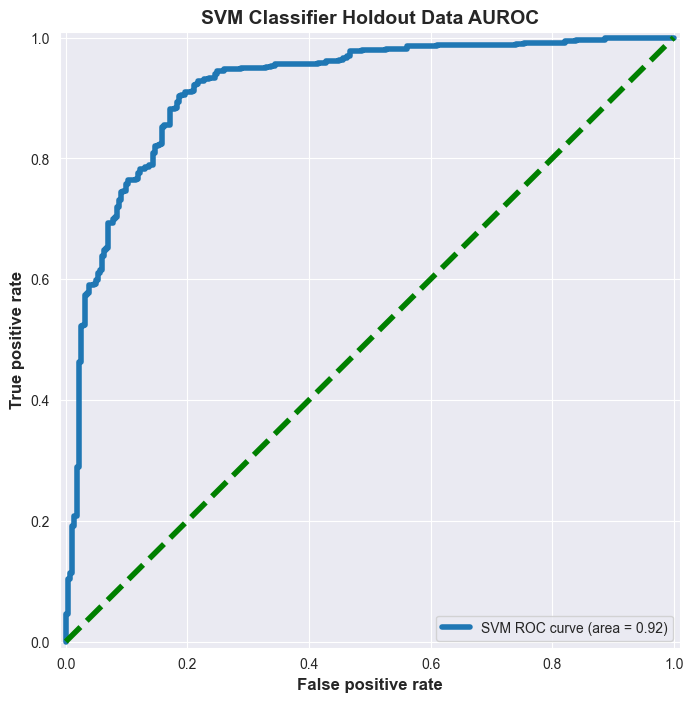

In [31]:
positive_label_index = np.where(svm_model.classes_ == 'BBB+')[0][0]
y_probabilities = svm_model.predict_proba(X_processed)[:,
                        positive_label_index]


# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(classification_holdout_y, y_probabilities,
                                    pos_label='BBB+')

roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 8))

plt.plot(
    fpr,
    tpr,
    lw=4,
    label='SVM ROC curve (area = %0.2f)' % roc_auc
)

plt.plot(
    [0, 1],
    [0, 1],
    color='green',
    lw=4,
    linestyle='--'
)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate', weight='bold', fontsize=12)
plt.ylabel('True positive rate', weight='bold', fontsize=12)
plt.title('SVM Classifier Holdout Data AUROC', weight='bold', fontsize=14)
plt.legend(loc='lower right')

plt.savefig(
    r'model_outputs\model_comparisions\svm_holdout_auroc.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

# Cherry Picking

In [32]:
#Make dataframe for molecules: Flortaucipir, Ginsenoside Rg1, Dabrafenib
smiles = np.array([[
    'C1=CC2=C(C=C1C3=CN=C(C=C3)[18F])NC4=C2C=NC=C4', 'BBB+'],
    ['CC(=CCC[C@@](C)([C@H]1CC[C@@]2([C@@H]1[C@@H](C[C@H]3[C@]2(C[C@@H]([C@@H]4[C@@]3(CC[C@@H](C4(C)C)O)C)O[C@H]5[C@@H]([C@H]([C@@H]([C@H](O5)CO)O)O)O)C)O)C)O[C@H]6[C@@H]([C@H]([C@@H]([C@H](O6)CO)O)O)O)C','BBB-'],
    ['CC(C)(C)C1=NC(=C(S1)C2=NC(=NC=C2)N)C3=C(C(=CC=C3)NS(=O)(=O)C4=C(C=CC=C4F)F)F', 'BBB-']
])

cherry_df = pd.DataFrame(smiles, columns=['SMILES', 'BBB+/BBB-'])

cherry_df

,SMILES,BBB+/BBB-
0,C1=CC2=C(C=C1C3=CN=C(C=C3)[18F])NC4=C2C=NC=C4,BBB+
1,CC(=CCC[C@@](C)([C@H]1CC[C@@]2([C@@H]1[C@@H](C...,BBB-
2,CC(C)(C)C1=NC(=C(S1)C2=NC(=NC=C2)N)C3=C(C(=CC=...,BBB-


In [33]:
cherry_df.to_csv(r'datasets\cherry_picked_dataset\cherry_picked_molecules.csv', index=False)


In [34]:
#Expand molecule descriptors
from dataset_expansion import dataset_feature_expansion

cherry_df_expanded, cherry_errors = dataset_feature_expansion(cherry_df)


Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - unable to change molecule rendering


Generating 210 RDKit descriptors:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 4096 Morgan fingerprints:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 167 MACCS keys:   0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
cherry_df_expanded

,SMILES,BBB+/BBB-,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,157_y,158_y,159_y,160_y,161_y,162_y,163_y,164_y,165_y,166_y
0,C1=CC2=C(C=C1C3=CN=C(C=C3)[18F])NC4=C2C=NC=C4,BBB+,12.870741,12.870741,0.466190,-0.466190,0.528178,11.250000,262.277938,252.197938,...,0,0,0,0,1,1,1,0,1,0
1,CC(=CCC[C@@](C)([C@H]1CC[C@@]2([C@@H]1[C@@H](C...,BBB-,12.555811,12.555811,0.000258,-1.607227,0.110176,52.642857,801.024000,728.448000,...,1,0,1,1,0,0,1,1,1,0
2,CC(C)(C)C1=NC(=C(S1)C2=NC(=NC=C2)N)C3=C(C(=CC=...,BBB-,15.679012,15.679012,0.021348,-4.777002,0.367049,12.057143,519.574000,499.414000,...,0,1,1,1,1,1,1,1,1,0


In [36]:
cherry_X = cherry_df_expanded.drop(['SMILES','BBB+/BBB-'], axis=1)

cherry_X.columns = cherry_X.columns.astype(str)

for label in cherry_X.columns:
    if label not in classification_holdout_X.columns:
        cherry_X = cherry_X.drop([label], axis=1)


cherry_X_processed = categorical_pipeline.transform(cherry_X)

cherry_y = cherry_df_expanded['BBB+/BBB-']



In [37]:
cherry_test = svm_model.predict(cherry_X_processed)
print(cherry_test)

['BBB-' 'BBB-' 'BBB-']
